In [22]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [23]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [24]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [25]:
def factor(df, window=20):
    df = df.copy()
    df['return'] = (df['close'] - df['open']) / df['open']
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        # 收益率缩尾处理
        returns = group['return'].copy()
        q_low = returns.quantile(0.05)
        q_hi = returns.quantile(0.95)
        returns = returns.clip(lower=q_low, upper=q_hi)
        
        time_idx = np.arange(len(group))
        up_mask = returns > 0
        down_mask = returns < 0
        flat_mask = returns == 0
        
        if up_mask.any():
            up_weights = returns[up_mask].abs() * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        if down_mask.any():
            down_weights = returns[down_mask].abs() * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        if flat_mask.any():
            flat_weights = group.loc[flat_mask, 'volume'] * (
                1 - (group.loc[flat_mask, 'high'] - group.loc[flat_mask, 'low']).abs() / group.loc[flat_mask, 'open']
            )
            G_f = np.sum(time_idx[flat_mask] * flat_weights) / flat_weights.sum()
        else:
            G_f = np.nan
            
        total_weights = (up_weights.sum() if up_mask.any() else 0) + \
                       (down_weights.sum() if down_mask.any() else 0) + \
                       (flat_weights.sum() if flat_mask.any() else 0)
        
        market_balance = (flat_weights.sum() if flat_mask.any() else 0) / total_weights
        
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d,
            'G_f': G_f,
            'market_balance': market_balance
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    residuals = []
    for i in range(window, len(daily_df)):
        # 使用过去20天数据训练回归模型，移除缺失值
        train_data = daily_df.iloc[i-window:i].dropna(subset=['G_u', 'G_d'])
        
        # 确保足够样本
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
        
        # 训练回归模型: G_d = beta * G_u + alpha
        X = train_data[['G_u']].values
        y = train_data['G_d'].values
        model = LinearRegression().fit(X, y)
        
        # 计算当日残差 (实际G_d - 预测G_d)
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    # 对齐残差序列
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 计算20日移动平均因子值
    daily_df['factor'] = daily_df['residual'].rolling(window).mean()
    
    # 将因子值映射回原始K线数据
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.027140
   Rank_IC (Spearman): 0.022265
📊 信息比率:
   IR: 0.336515
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127291
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


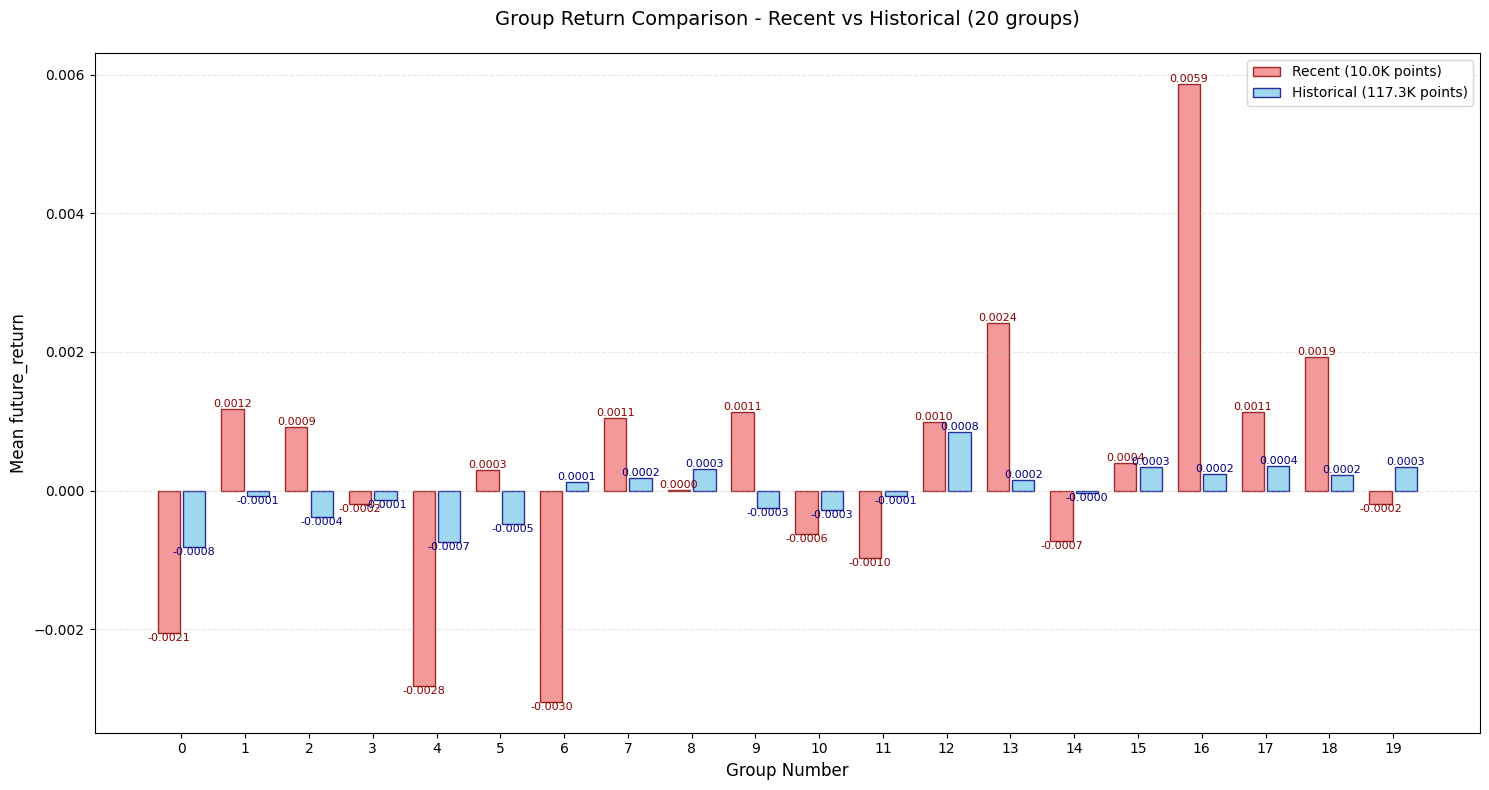

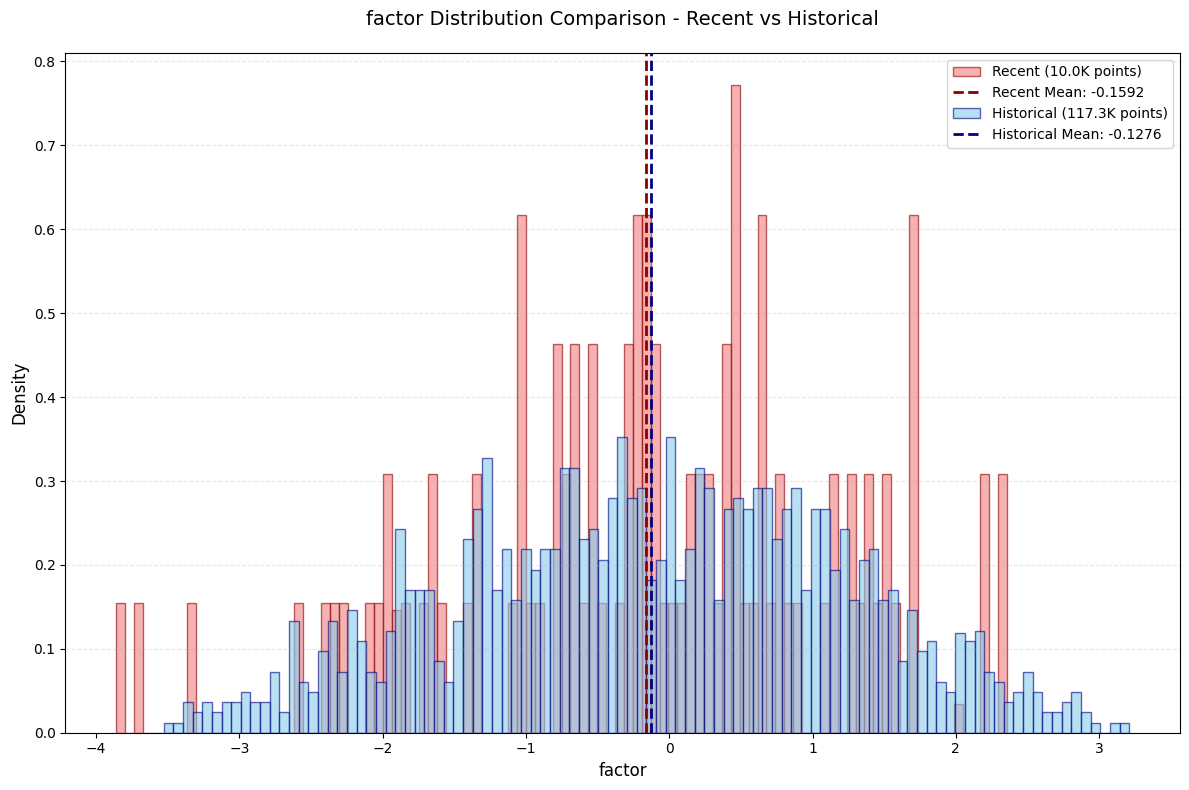

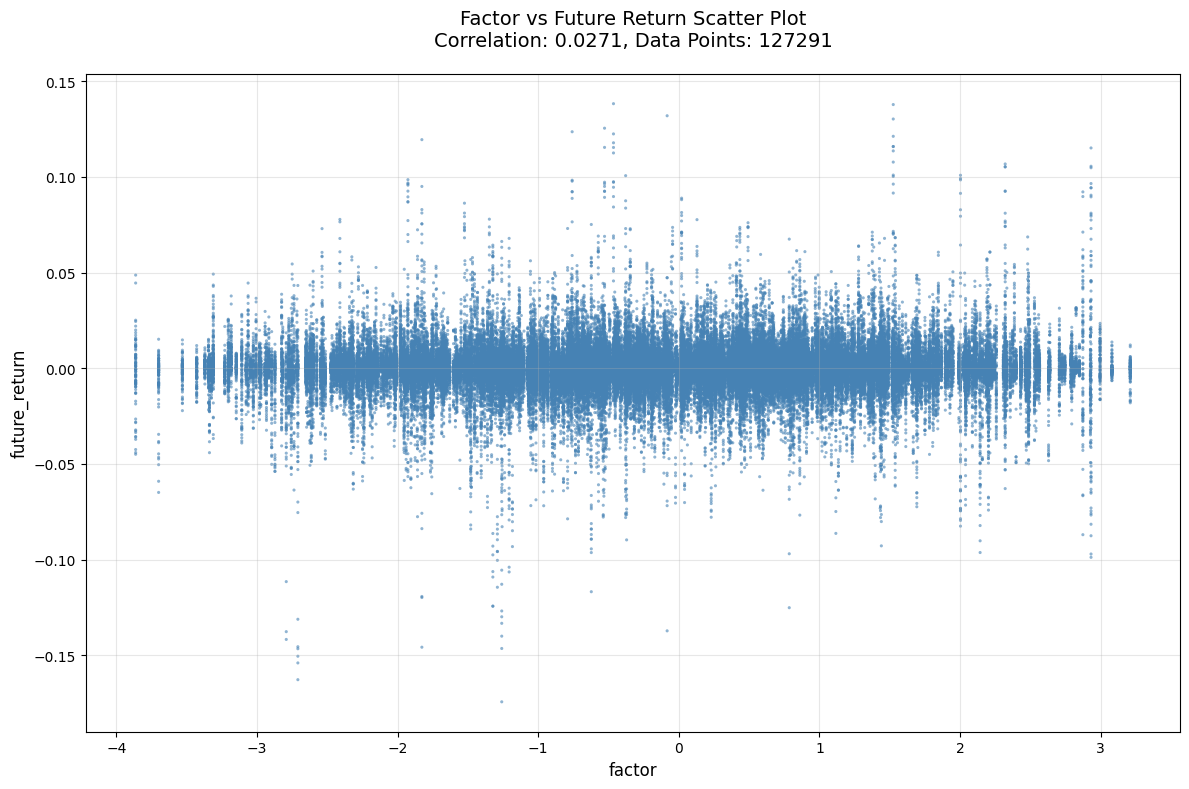

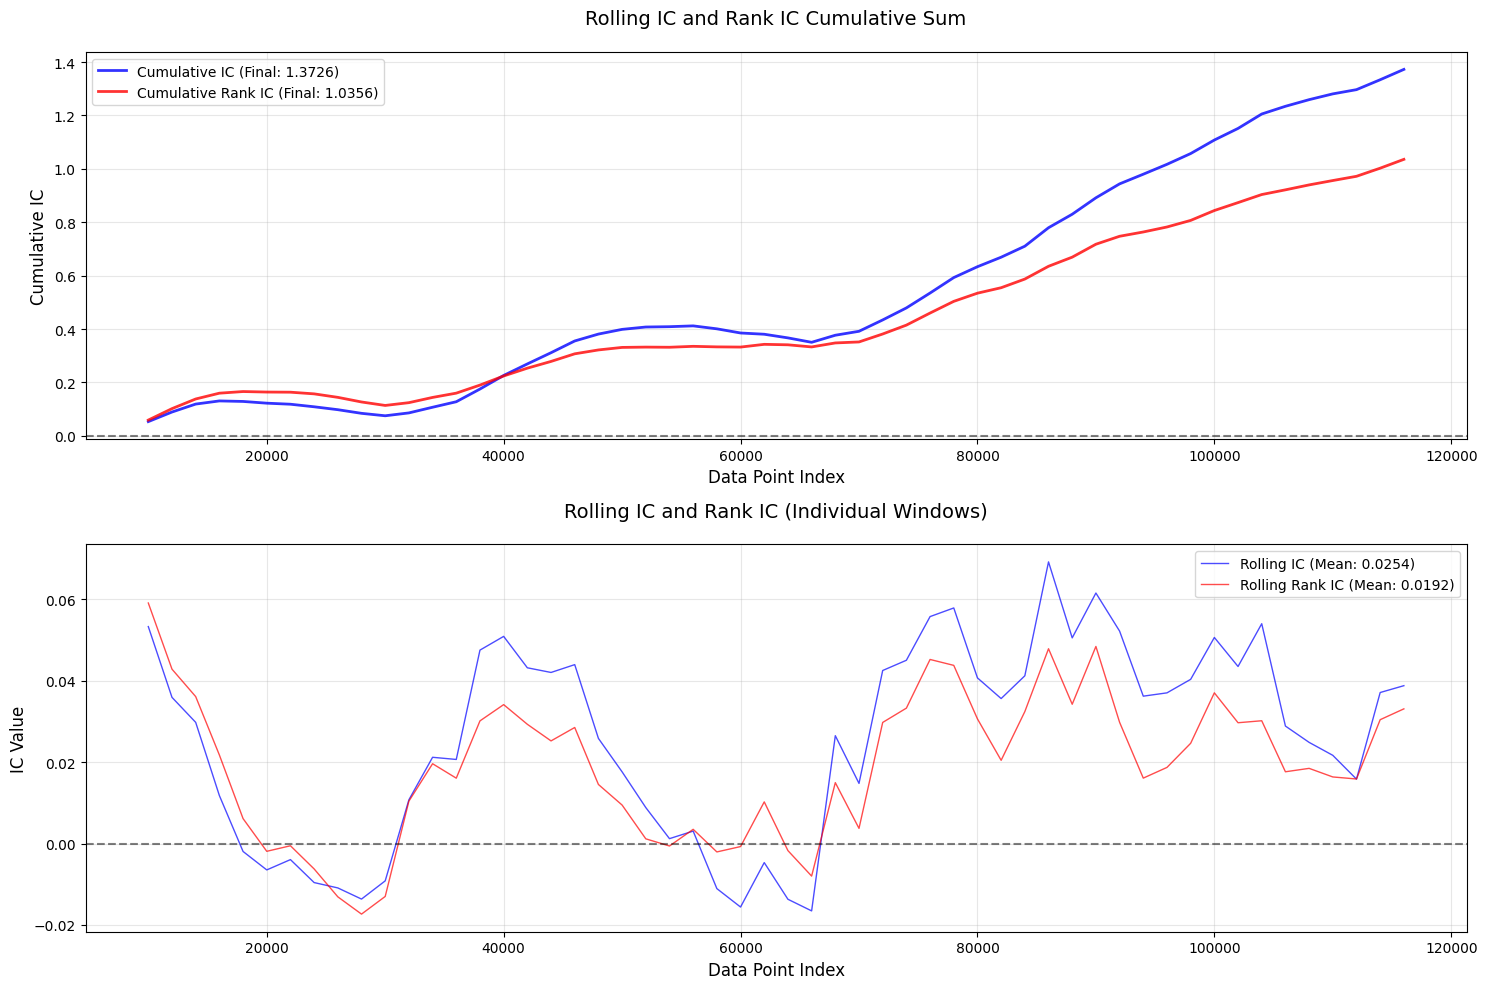

✅ 已显示 4 个图片
----------------------------------------


In [26]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [27]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.03160317967343008,
 -0.003585870668182978,
 -0.00361229320221458,
 0.025470223380556337,
 -0.020719163837704852,
 0.008871068285157158,
 -0.00599303068021832,
 0.009102630784780422,
 0.00022128928597784126,
 0.007620717390561603]

In [28]:
print(result)

{'correlation_analysis': {'IC': 0.027140004793875145, 'Rank_IC': 0.022265449036424093}, 'information_ratio': {'IR': 0.3365154990823257, 'group_correlations': [0.03160317967343008, -0.003585870668182978, -0.00361229320221458, 0.025470223380556337, -0.020719163837704852, 0.008871068285157158, -0.00599303068021832, 0.009102630784780422, 0.00022128928597784126, 0.007620717390561603], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -3.8620  -2.4031   -2.8472      -0.0008      0.0130   6432
1      -2.3863  -1.9297   -2.1666      -0.0003      0.0107   6331
2      -1.9259  -1.6516   -1.7909      -0.0001      0.0125   6336
3      -1.6468  -1.3226   -1.4351      -0.0001      0.0121   6432
4      -1.3220  -1.0733   -1.2103      -0.0007      0.0133   6336
5      -1.0727  -0.8392   -0.9656      -0.0009      0.0109   6336
6      -0.8383  -0.6708   -0.7419     